# Evaluating Fairness in Machine Learning: Comparative Analysis and Benchmarking of Fairlearn and AIF360 | Adult Census Income

In [112]:
%load_ext autoreload
%autoreload 2

import os
import random

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

from src.constants import RANDOM_STATE, DEFAULT_MODEL_CONFIG, METRICFRAME_METRICS
from src.evaluation import plot_roc, print_confusion_matrix, calculate_fairlearn_metrics, calculate_aif360_metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
sklearn.set_config(transform_output="pandas")

## Ensure reproducibility

Set random seeds for reproducibility.

In [83]:
np.random.seed(RANDOM_STATE)
os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)
random.seed(RANDOM_STATE)

## Load data

In [84]:
TARGET = "income"
PROTECTED_ATTRIBUTE = "gender"

In [85]:
data_raw = pd.read_csv("../data/adult.csv")
data = data_raw.copy()

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [87]:
data.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [88]:
data[TARGET].value_counts()

income
<=50K    37155
>50K     11687
Name: count, dtype: int64

In [89]:
data[PROTECTED_ATTRIBUTE].value_counts()

gender
Male      32650
Female    16192
Name: count, dtype: int64

In [90]:
data.income = data.income.replace({">50K": 1, "<=50K": 0})

/var/folders/jw/2qdy78hj131965_p8gvscxqc0000gq/T/ipykernel_12004/3664918217.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.income = data.income.replace({">50K": 1, "<=50K": 0})


In [91]:
y = data.loc[:, TARGET]
z = data.loc[:, PROTECTED_ATTRIBUTE]
X = data.drop(columns=TARGET)

In [92]:
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [93]:
MODEL_CONFIG = dict(DEFAULT_MODEL_CONFIG, cat_features=X.select_dtypes("object").columns.to_list())

In [94]:
default_model = CatBoostClassifier(**MODEL_CONFIG)
model = default_model.copy()

In [95]:
model.fit(X_train, y_train)

0:	learn: 0.6834529	total: 22.6ms	remaining: 1m 7s
250:	learn: 0.3245970	total: 3.94s	remaining: 43.2s
500:	learn: 0.3056956	total: 7.41s	remaining: 36.9s
750:	learn: 0.2972588	total: 10.6s	remaining: 31.8s
1000:	learn: 0.2919571	total: 14.2s	remaining: 28.3s
1250:	learn: 0.2871027	total: 18.2s	remaining: 25.4s
1500:	learn: 0.2837078	total: 23.7s	remaining: 23.6s
1750:	learn: 0.2816475	total: 26.4s	remaining: 18.8s
2000:	learn: 0.2799080	total: 29.2s	remaining: 14.6s
2250:	learn: 0.2784999	total: 31.9s	remaining: 10.6s
2500:	learn: 0.2773517	total: 34.7s	remaining: 6.92s
2750:	learn: 0.2763439	total: 37.4s	remaining: 3.39s
2999:	learn: 0.2754376	total: 40.4s	remaining: 0us


In [96]:
y_pred = pd.Series(model.predict(X_test), name="y_pred", index=y_test.index)

In [97]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      7431
           1       0.78      0.64      0.71      2338

    accuracy                           0.87      9769
   macro avg       0.84      0.79      0.81      9769
weighted avg       0.87      0.87      0.87      9769


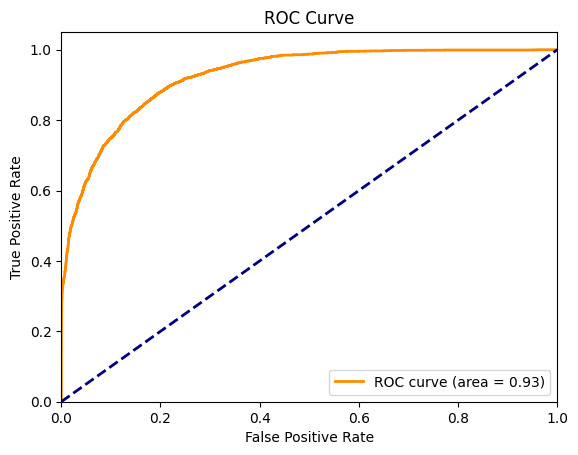

In [98]:
fig, ax = plt.subplots()
plot_roc(model, X_test, y_test, ax)

In [133]:
print_confusion_matrix(model, X_test, y_test)

Confusion Matrix:
[[7012  419]
 [ 835 1503]]


## Fairness assessment

### Fairlearn

#### Detection

In [113]:
from fairlearn.metrics import MetricFrame

In [134]:
mf = MetricFrame(
    metrics=METRICFRAME_METRICS,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=z_test,
    random_state=RANDOM_STATE,
)

In [135]:
mf.overall

tpr         0.642857
fpr         0.056385
sel         0.196745
count    9769.000000
dtype: float64

In [136]:
mf.by_group

,tpr,fpr,sel,count
gender,,,,
Female,0.566474,0.016632,0.075495,3232.0
Male,0.656124,0.081628,0.256693,6537.0


In [137]:
calculate_fairlearn_metrics(y_test, y_pred, z_test)

,metric,type,method,value
8,demographic_parity,difference,between_groups,0.181198
10,demographic_parity,difference,to_overall,0.121250
9,demographic_parity,ratio,between_groups,0.294107
11,demographic_parity,ratio,to_overall,0.383721
0,equal_opportunity,difference,between_groups,0.089651
2,equal_opportunity,difference,to_overall,0.076383
1,equal_opportunity,ratio,between_groups,0.863364
3,equal_opportunity,ratio,to_overall,0.881182
4,equalized_odds,difference,between_groups,0.089651
6,equalized_odds,difference,to_overall,0.076383


#### Mitigation

In [138]:
from fairlearn.reductions import DemographicParity, ExponentiatedGradient

In [139]:
reduction = ExponentiatedGradient(estimator=default_model.copy(), constraints=DemographicParity(difference_bound=0.01), max_iter=10)
reduction.fit(X_train, y_train, sensitive_features=z_train)

/opt/homebrew/Caskroom/miniconda/base/envs/fairness-toolkits/lib/python3.10/site-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/opt/homebrew/Caskr

0:	learn: 0.6834529	total: 61ms	remaining: 3m 3s
250:	learn: 0.3245970	total: 4.89s	remaining: 53.6s
500:	learn: 0.3056956	total: 10.5s	remaining: 52.3s
750:	learn: 0.2972588	total: 12.8s	remaining: 38.2s
1000:	learn: 0.2919571	total: 15.1s	remaining: 30.1s
1250:	learn: 0.2871027	total: 17.6s	remaining: 24.6s
1500:	learn: 0.2837078	total: 20.2s	remaining: 20.2s
1750:	learn: 0.2816475	total: 22.7s	remaining: 16.2s
2000:	learn: 0.2799080	total: 25.2s	remaining: 12.6s
2250:	learn: 0.2784999	total: 27.5s	remaining: 9.16s
2500:	learn: 0.2773517	total: 29.8s	remaining: 5.95s
2750:	learn: 0.2763439	total: 32.1s	remaining: 2.91s
2999:	learn: 0.2754376	total: 34.5s	remaining: 0us
0:	learn: 0.6834529	total: 18.4ms	remaining: 55.3s
250:	learn: 0.3245970	total: 2.24s	remaining: 24.5s
500:	learn: 0.3056956	total: 4.43s	remaining: 22.1s
750:	learn: 0.2972588	total: 6.98s	remaining: 20.9s
1000:	learn: 0.2919571	total: 9.25s	remaining: 18.5s
1250:	learn: 0.2871027	total: 11.6s	remaining: 16.2s
1500:	l

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x2b48f3340>,
                      estimator=<catboost.core.CatBoostClassifier object at 0x2b48f3be0>,
                      max_iter=10, nu=0.0008363288569675996)

In [140]:
y_pred_reduced = reduction.predict(X_test)

In [141]:
print(classification_report(y_test, y_pred_reduced))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      7431
           1       0.79      0.55      0.65      2338

    accuracy                           0.86      9769
   macro avg       0.83      0.75      0.78      9769
weighted avg       0.85      0.86      0.85      9769


### AIF360

#### Detection

_"Since the main computation of confusion matrices is common for a large set of metrics, we utilize memoization and caching of computations for performance on large-scale datasets."_

In [163]:
priv_group = "Male"

In [164]:
calculate_aif360_metrics(y_test, y_pred, z_test, priv_group=priv_group)

,metric,type,method,value
0,demographic_parity,difference,other,-0.181198
1,demographic_parity,ratio,other,0.294107
2,equal_opportunity,difference,other,-0.089651


#### Mitigation

In [165]:
from aif360.sklearn.inprocessing import ExponentiatedGradientReduction as ExponentiatedGradientReductionAif

In [166]:
# drop_prot_attr=True is incompatible with catboost cat_features parameter
reduction_aif = ExponentiatedGradientReductionAif(prot_attr=PROTECTED_ATTRIBUTE, estimator=default_model.copy(), constraints=DemographicParity(difference_bound=0.01), max_iter=10, drop_prot_attr=False)

In [167]:
reduction_aif.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniconda/base/envs/fairness-toolkits/lib/python3.10/site-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/opt/homebrew/Caskr

0:	learn: 0.6834529	total: 56.6ms	remaining: 2m 49s
250:	learn: 0.3245970	total: 5.58s	remaining: 1m 1s
500:	learn: 0.3056956	total: 8.95s	remaining: 44.6s
750:	learn: 0.2972588	total: 11.6s	remaining: 34.8s
1000:	learn: 0.2919571	total: 14.5s	remaining: 28.9s
1250:	learn: 0.2871027	total: 17.2s	remaining: 24.1s
1500:	learn: 0.2837078	total: 20s	remaining: 19.9s
1750:	learn: 0.2816475	total: 22.9s	remaining: 16.3s
2000:	learn: 0.2799080	total: 25.6s	remaining: 12.8s
2250:	learn: 0.2784999	total: 28.5s	remaining: 9.47s
2500:	learn: 0.2773517	total: 31.3s	remaining: 6.24s
2750:	learn: 0.2763439	total: 34.2s	remaining: 3.1s
2999:	learn: 0.2754376	total: 36.9s	remaining: 0us
0:	learn: 0.6834529	total: 65.7ms	remaining: 3m 17s
250:	learn: 0.3245970	total: 2.67s	remaining: 29.2s
500:	learn: 0.3056956	total: 5.25s	remaining: 26.2s
750:	learn: 0.2972588	total: 8.14s	remaining: 24.4s
1000:	learn: 0.2919571	total: 10.8s	remaining: 21.6s
1250:	learn: 0.2871027	total: 13.5s	remaining: 18.8s
1500:	

ExponentiatedGradientReduction(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x2b5fe83a0>,
                               drop_prot_attr=False,
                               estimator=<catboost.core.CatBoostClassifier object at 0x2b5fe8340>,
                               max_iter=10, prot_attr='gender')

In [168]:
y_pred_reduced_aif = reduction_aif.predict(X_test)

In [169]:
calculate_aif360_metrics(y_test, y_pred_reduced_aif, z_test, priv_group=priv_group)

,metric,type,method,value
0,demographic_parity,difference,other,-0.025874
1,demographic_parity,ratio,other,0.851895
2,equal_opportunity,difference,other,0.279099


In [170]:
print(classification_report(y_test, y_pred_reduced_aif))


              precision    recall  f1-score   support

           0       0.87      0.95      0.91      7431
           1       0.79      0.55      0.65      2338

    accuracy                           0.86      9769
   macro avg       0.83      0.75      0.78      9769
weighted avg       0.85      0.86      0.85      9769
